In [2]:
from google.colab import files

In [3]:
files.upload()

Saving hw3_utils.py to hw3_utils.py


{'hw3_utils.py': b'import os\nimport gzip\nimport struct\nimport array\nimport numpy as np\nfrom urllib.request import urlretrieve\n\nimport torch\nfrom torch.utils.data import Dataset\n\n\nBASE_URL = \'http://yann.lecun.com/exdb/mnist/\'\n\n\n# Helper functions and imports\ndef download(url, filename):\n    if not os.path.exists(\'./data\'):\n        os.makedirs(\'./data\')\n    out_file = os.path.join(\'./data\', filename)\n    if not os.path.isfile(out_file):\n        urlretrieve(url, out_file)\n\n\ndef mnist():\n    def parse_labels(filename):\n        with gzip.open(filename, \'rb\') as fh:\n            magic, num_data = struct.unpack(">II", fh.read(8))\n            return np.array(array.array("B", fh.read()), dtype=np.uint8)\n\n    def parse_images(filename):\n        with gzip.open(filename, \'rb\') as fh:\n            magic, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))\n            return np.array(array.array("B", fh.read()), dtype=np.uint8).reshape(num_data, rows

In [8]:
import os
import gzip
import struct
import array
import numpy as np
from urllib.request import urlretrieve

import torch
from torch.utils.data import Dataset

In [11]:
BASE_URL = 'http://yann.lecun.com/exdb/mnist/'


# Helper functions and imports
def download(url, filename):
    if not os.path.exists('./data'):
        os.makedirs('./data')
    out_file = os.path.join('./data', filename)
    if not os.path.isfile(out_file):
        urlretrieve(url, out_file)


In [10]:
def mnist():
    def parse_labels(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data = struct.unpack(">II", fh.read(8))
            return np.array(array.array("B", fh.read()), dtype=np.uint8)

    def parse_images(filename):
        with gzip.open(filename, 'rb') as fh:
            magic, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
            return np.array(array.array("B", fh.read()), dtype=np.uint8).reshape(num_data, rows, cols)

    for filename in ['train-images-idx3-ubyte.gz',
                     'train-labels-idx1-ubyte.gz',
                     't10k-images-idx3-ubyte.gz',
                     't10k-labels-idx1-ubyte.gz']:
        download(BASE_URL + filename, filename)

    train_images = parse_images('./data/train-images-idx3-ubyte.gz')
    train_labels = parse_labels('./data/train-labels-idx1-ubyte.gz')
    test_images  = parse_images('./data/t10k-images-idx3-ubyte.gz')
    test_labels  = parse_labels('./data/t10k-labels-idx1-ubyte.gz')
    return train_images, train_labels, test_images, test_labels

In [12]:
def load_mnist():
    partial_flatten = lambda x : np.reshape(x, (x.shape[0], np.prod(x.shape[1:])))
    one_hot = lambda x, k: np.array(x[:,None] == np.arange(k)[None, :], dtype=int)
    train_images, train_labels, test_images, test_labels = mnist()
    train_images = partial_flatten(train_images) / 255.0
    test_images  = partial_flatten(test_images)  / 255.0
    train_labels = one_hot(train_labels, 10)
    test_labels = one_hot(test_labels, 10)
    N_data = train_images.shape[0]
    train_images = torch.from_numpy(np.round(train_images[0:10000])).float()
    train_labels = torch.from_numpy(train_labels[0:10000]).float()
    test_images = torch.from_numpy(np.round(test_images[0:10000])).float()
    test_labels = torch.from_numpy(test_labels[0:10000])
    return N_data, train_images, train_labels, test_images, test_labels

In [13]:
def batch_indices(iter, num_batches, batch_size):
    # iter: iteration index
    # num_batches: number of batches
    # batch_size: batch size
    idx = iter % num_batches
    return slice(idx * batch_size, (idx+1) * batch_size)


# write a function to reshape 784 array into a 28x28 image for plotting
def array_to_image(array):
    return np.reshape(np.array(array), [28, 28])


# concatenate the images for plotting
def concat_images(images, row, col, padding = 3):
    result = np.zeros((28*row+(row-1)*padding,28*col+(col-1)*padding))
    for i in range(row):
        for j in range(col):
            result[i*28+(i*padding):i*28+(i*padding)+28, j*28+(j*padding):j*28+(j*padding)+28] = images[i+j*row]
    return result

In [4]:
import sys
import argparse
import matplotlib.pyplot as plt
plt.rcParams["axes.grid"] = False
import matplotlib.image
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from hw3_utils import array_to_image, concat_images, batch_indices, load_mnist


In [6]:
# The "encoder" model q(z|x)
class Encoder(nn.Module):
    def __init__(self, latent_dimension, hidden_units, data_dimension):
        super(Encoder, self).__init__()
        
        self.fc1 = nn.Linear(data_dimension, hidden_units)
        self.fc2_mu = nn.Linear(hidden_units, latent_dimension)
        self.fc2_sigma = nn.Linear(hidden_units, latent_dimension)

    def forward(self, x):
        hidden = torch.tanh(self.fc1(x))
        mu = self.fc2_mu(hidden)
        log_sigma_square = self.fc2_sigma(hidden)
        sigma_square = torch.exp(log_sigma_square)  
        return mu, sigma_square


# "decoder" Model p(x|z)
class Decoder(nn.Module):
    def __init__(self, latent_dimension, data_dimension,hidden_units=500):
        super(Decoder, self).__init__()

        # fc1: a fully connected layer with 500 hidden units. 
        # fc2: a fully connected layer with 500 hidden units.
        self.fc1_dec = nn.Linear(latent_dimension, 500)
        self.fc2_dec = nn.Linear(500, 784)

    def forward(self, z):
      
        # The first layer is followed by a tanh non-linearity and the second layer by a sigmoid.
        p = torch.tanh(self.fc1_dec(z))
        p = torch.sigmoid(self.fc2_dec(p))
        return p



In [7]:
# VAE model
class VAE(nn.Module):
    def __init__(self, args):
        super(VAE, self).__init__()
        self.latent_dimension = args.latent_dimension
        self.hidden_units =  args.hidden_units
        self.data_dimension = args.data_dimension
        self.resume_training = args.resume_training
        self.batch_size = args.batch_size
        self.num_epoches = args.num_epoches =200
        self.e_path = args.e_path
        self.d_path = args.d_path

        N_data, self.train_images, self.train_labels, test_images, test_labels = load_mnist()

        self.encoder = Encoder(self.latent_dimension, self.hidden_units, self.data_dimension)
        self.decoder = Decoder(self.latent_dimension, self.hidden_units, self.data_dimension)

        # Load the trained model parameters
        if self.resume_training:
            self.encoder.load_state_dict(torch.load(self.e_path))
            self.decoder.load_state_dict(torch.load(self.d_path))

    # Sample from Diagonal Gaussian z~N(μ,σ^2 I) 
    @staticmethod
    def sample_diagonal_gaussian(mu, sigma_square):
        sigma = (torch.sqrt(sigma_square)).reshape(mu.shape[0],mu.shape[1])
        sample = mu + torch.randn(size = (mu.shape[0],mu.shape[1]))*sigma
        
        return sample

    # Sampler from Bernoulli
    @staticmethod
    def sample_Bernoulli(p):
        # Input: 
        #   p: the probability of pixels labeled 1 [batch_size x data_dimension]
        # Output:
        #   x: pixels'labels [batch_size x data_dimension], type should be torch.float32
        x = torch.bernoulli(p)
        # TODO: Implement a sampler from a Bernoulli distribution
        
        return x


    # Compute Log-pdf of z under Diagonal Gaussian N(z|μ,σ^2 I)
    @staticmethod
    def logpdf_diagonal_gaussian(z, mu, sigma_square):
        # Input:
        #   z: sample [batch_size x latent_dimension]
        #   mu: mean of the gaussian distribution [batch_size x latent_dimension]
        #   sigma_square: variance of the gaussian distribution [batch_size x latent_dimension]
        # Output:
        #    logprob: log-probability of a diagomnal gaussian [batch_size]
        from torch.distributions.multivariate_normal import MultivariateNormal
        logprob = torch.zeros((mu.shape[0]))
        for i in range(mu.shape[0]):
            dist = MultivariateNormal(mu[i], sigma_square[i]*torch.eye((mu.shape[1])))
            logprob[i] = dist.log_prob(z[i])
        
        return logprob

    # Compute log-pdf of x under Bernoulli 
    @staticmethod
    def logpdf_bernoulli(x, p):
        # Input:
        #   x: samples [batch_size x data_dimension]
        #   p: the probability of the x being labeled 1 (p is the output of the decoder) [batch_size x data_dimension]
        # Output:
        #   logprob: log-probability of a bernoulli distribution [batch_size]
        
        
        logprob = (x*torch.log(p) + (1-x)*torch.log(1-p)).sum(axis =1)        
        return logprob
    
    # Sample z ~ q(z|x)
    def sample_z(self, mu, sigma_square):
        # input:
        #   mu: mean of the gaussian [batch_size x latent_dimension]
        #   sigma_square: variance of the gaussian [batch_size x latent_dimension]
        # Output:
        #   zs: samples from q(z|x) [batch_size x latent_dimension] 
        zs = self.sample_diagonal_gaussian(mu, sigma_square)
        return zs 


    # Variational Objective
    def elbo_loss(self, sampled_z, mu, sigma_square, x, p):
        # Inputs
        #   sampled_z: samples z from the encoder [batch_size x latent_dimension]
        #   mu:
        #   sigma_square: parameters of q(z|x) [batch_size x latent_dimension]
        #   x: data samples [batch_size x data_dimension]
        #   p: the probability of a pixel being labeled 1 [batch_size x data_dimension]
        # Output
        #   elbo: the ELBO loss (scalar)

        # log_q(z|x) logprobability of z under approximate posterior N(μ,σ)
        log_q = self.logpdf_diagonal_gaussian(sampled_z, mu, sigma_square)
        
        # log_p_z(z) log probability of z under prior
        z_mu = torch.FloatTensor([0]*self.latent_dimension).repeat(sampled_z.shape[0], 1)
        z_sigma = torch.FloatTensor([1]*self.latent_dimension).repeat(sampled_z.shape[0], 1)
        log_p_z = self.logpdf_diagonal_gaussian(sampled_z, z_mu, z_sigma)

        # log_p(x|z) - conditional probability of data given latents.
        log_p = self.logpdf_bernoulli(x, p)
        
        # TODO: implement the ELBO loss using log_q, log_p_z and log_p
        elbo = (log_p+log_p_z-log_q).mean()
        return elbo


    def train(self):
        
        # Set-up ADAM optimizer
        params = list(self.encoder.parameters()) + list(self.decoder.parameters())
        adam_optimizer = optim.Adam(params)

        # Train for ~200 epochs 
        num_batches = int(np.ceil(len(self.train_images) / self.batch_size))
        num_iters = 200 * num_batches
        
        for i in range(num_iters):
            x_minibatch = self.train_images[batch_indices(i, num_batches, self.batch_size),:]
            adam_optimizer.zero_grad()

            mu, sigma_square = self.encoder(x_minibatch)
            zs = self.sample_z(mu, sigma_square)
            p = self.decoder(zs)
            elbo = self.elbo_loss(zs, mu, sigma_square, x_minibatch, p)
            total_loss = -elbo
            total_loss.backward()
            adam_optimizer.step()

            if i%100 == 0:
                print("Epoch: " + str(i//num_batches) + ", Iter: " + str(i) + ", ELBO:" + str(elbo.item()))

        # Save Optimized Model Parameters
        torch.save(self.encoder.state_dict(), self.e_path)
        torch.save(self.decoder.state_dict(), self.d_path)


    # Generate digits using the VAE
    def visualize_data_space(self):
        # TODO: Sample 10 z from prior 
        images = torch.zeros((20,28,28)).detach().numpy()
        sample_x = torch.zeros((10,28,28)).detach().numpy()
        # TODO: For each z, plot p(x|z)
        for i in range(10):
          mu = torch.Tensor([0.0,0.0]).reshape(1,2)
          sigma_square = torch.Tensor([1.0,1.0]).reshape(1,2)
          z = self.sample_diagonal_gaussian(mu, sigma_square)
          output_dec = (self.decoder(z).view(-1,1,28,28))
          sample_x = self.sample_Bernoulli(output_dec)
          images[10+i] = array_to_image(self.sample_Bernoulli(output_dec).detach().numpy())
          output_img = array_to_image(output_dec.detach().numpy())
          images[i] = output_img
                  

        concatenated_image= concat_images(images, 10, 2, padding = 3)
  
        import cv2
        cv2.imwrite("ques1_cv2.png",concatenated_image*255)
      
        
    # Produce a scatter plot in the latent space, where each point in the plot will be the mean vector 
    # for the distribution $q(z|x)$ given by the encoder. Further, we will colour each point in the plot 
    # by the class label for the input data. Each point in the plot is colored by the class label for 
    # the input data.
    # The latent space should have learned to distinguish between elements from different classes, even though 
    # we never provided class labels to the model!
    def visualize_latent_space(self):
        z_mean = torch.zeros((self.train_images.shape[0],2))
        # TODO: Encode the training data self.train_images
        for i in range(self.train_images.shape[0]):
            z_mean[i],_ = self.encoder(self.train_images[i])
            
         
        # TODO: Take the mean vector of each encoding
        labels = torch.zeros((self.train_labels.shape[0],1))
        for i in range(self.train_labels.shape[0]):
            labels[i]= torch.Tensor(torch.where(self.train_labels[i]==1))

        # TODO: Plot these mean vectors in the latent space with a scatter
        # Colour each point depending on the class label 
        fig, ax = plt.subplots()
        for color in ['0:blue', '1:orange', '2:green', "3:yellow", "4:red","5:pink","6:black","7:cyan","8:magenta","9:violet"]:
          ax.scatter(z_mean[:,0].detach().numpy(), z_mean[:,1].detach().numpy(), c=labels, label=color,
               alpha=0.3, edgecolors='none')

        ax.legend()
        plt.title("Latent_Space_Visualization")
        plt.xlabel('Latent dimension 1')
        plt.ylabel('Latent dimension 2')
        plt.show()
        fig.savefig("latent_space.png", cmap = "Greys")    


    # Function which gives linear interpolation z_α between za and zb
    @staticmethod
    def interpolate_mu(mua, mub, alpha = 0.1):
        return alpha*mua + (1-alpha)*mub


    # A common technique to assess latent representations is to interpolate between two points.
    # Here we will encode 3 pairs of data points with different classes.
    # Then we will linearly interpolate between the mean vectors of their encodings. 
    # We will plot the generative distributions along the linear interpolation.
    def visualize_inter_class_interpolation(self):
        labels = torch.zeros((self.train_labels.shape[0],1))
        for i in range(self.train_labels.shape[0]):
            labels[i]= torch.Tensor(torch.where(self.train_labels[i]==1))
        label_0_idx = torch.where(labels ==0)[0][:2]
        label_1_idx = torch.where(labels==1)[0][:2]
        label_2_idx = torch.where(labels==2)[0][:2]
        # TODO: Sample 3 pairs of data with different classes
        sample_1 = self.train_images[label_0_idx]
        sample_2 = self.train_images[label_1_idx]
        sample_3 = self.train_images[label_2_idx]
        
        
        # TODO: Encode the data in each pair, and take the mean vectors
        mean_sample1,_ = self.encoder(sample_1)
        mean_sample2,_ = self.encoder(sample_2)
        mean_sample3,_ = self.encoder(sample_3)

        # TODO: Linearly interpolate between these mean vectors (Use the function interpolate_mu)
        lin_int_1 = self.interpolate_mu(mean_sample1[0], mean_sample1[1], alpha = 0.1)
        lin_int_2 = self.interpolate_mu(mean_sample2[0], mean_sample2[1], alpha = 0.1)
        lin_int_3 = self.interpolate_mu(mean_sample3[0], mean_sample3[1], alpha = 0.1)
        # TODO: Along the interpolation, plot the distributions p(x|z_α)
        mu = lin_int_1.reshape(1,2)
        sigma_square = torch.Tensor([1.0,1.0]).reshape(1,2)
        z = self.sample_diagonal_gaussian(mu, sigma_square)
        lin_images = torch.zeros((3,28,28)).detach().numpy()
        z = self.sample_diagonal_gaussian(mu, sigma_square)
        lin_images[0] = array_to_image(self.decoder(z).reshape(28,28).detach().numpy())
        mu = lin_int_2.reshape(1,2)
        z = self.sample_diagonal_gaussian(mu, sigma_square)
        lin_images[1] = array_to_image(self.decoder(z).reshape(28,28).detach().numpy())
        mu = lin_int_3.reshape(1,2)
        z = self.sample_diagonal_gaussian(mu, sigma_square)
        lin_images[2] = array_to_image(self.decoder(z).reshape(28,28).detach().numpy())
        
        # Concatenate these plots into one figure
        concatenated_image_interclass= concat_images(lin_images, 1, 3, padding = 3)
        import cv2
        cv2.imwrite("ques3_cv2.png",concatenated_image_interclass*255)
        
        
      


In [ ]:
def parse_args():
    parser = argparse.ArgumentParser(description=globals()['__doc__'])
    parser.add_argument('-f')

    parser.add_argument('--e_path', type=str, default="./e_params.pkl", help='Path to the encoder parameters.')
    parser.add_argument('--d_path', type=str, default="./d_params.pkl", help='Path to the decoder parameters.')
    parser.add_argument('--hidden_units', type=int, default=500, help='Number of hidden units of the encoder and decoder models.')
    parser.add_argument('--latent_dimension', type=int, default='2', help='Dimensionality of the latent space.')
    parser.add_argument('--data_dimension', type=int, default='784', help='Dimensionality of the data space.')
    parser.add_argument('--resume_training', action='store_true', help='Whether to resume training')
    parser.add_argument('--seed', type=int, default=1234, help='Random seed')
    parser.add_argument('--num_epoches', type=int, default=200, help='Number of epochs for training.')
    parser.add_argument('--batch_size', type=int, default=100, help='Batch size.')

    
    args = parser.parse_args()


    return args


In [ ]:
def main():
    
    # read the function arguments
    args = parse_args()
    

    # set the random seed 
    torch.manual_seed(args.seed)
    np.random.seed(args.seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(args.seed)
    
    # train the model 
    vae = VAE(args)
    vae.train()

    # visualize the latent space
    vae.visualize_data_space()
    vae.visualize_latent_space()
    vae.visualize_inter_class_interpolation()



Epoch: 0, Iter: 0, ELBO:-548.4129028320312
Epoch: 1, Iter: 100, ELBO:-182.0055694580078
Epoch: 2, Iter: 200, ELBO:-178.53799438476562
Epoch: 3, Iter: 300, ELBO:-175.31761169433594
Epoch: 4, Iter: 400, ELBO:-173.33831787109375
Epoch: 5, Iter: 500, ELBO:-169.8173065185547
Epoch: 6, Iter: 600, ELBO:-167.0365447998047
Epoch: 7, Iter: 700, ELBO:-165.3115997314453
Epoch: 8, Iter: 800, ELBO:-163.4532012939453
Epoch: 9, Iter: 900, ELBO:-162.02813720703125
Epoch: 10, Iter: 1000, ELBO:-160.77239990234375
Epoch: 11, Iter: 1100, ELBO:-159.6454620361328
Epoch: 12, Iter: 1200, ELBO:-158.81666564941406
Epoch: 13, Iter: 1300, ELBO:-157.68927001953125
Epoch: 14, Iter: 1400, ELBO:-157.62933349609375
Epoch: 15, Iter: 1500, ELBO:-156.66494750976562
Epoch: 16, Iter: 1600, ELBO:-155.40748596191406
Epoch: 17, Iter: 1700, ELBO:-155.17710876464844
Epoch: 18, Iter: 1800, ELBO:-153.99888610839844
Epoch: 19, Iter: 1900, ELBO:-154.29290771484375
Epoch: 20, Iter: 2000, ELBO:-153.02545166015625
Epoch: 21, Iter: 2100

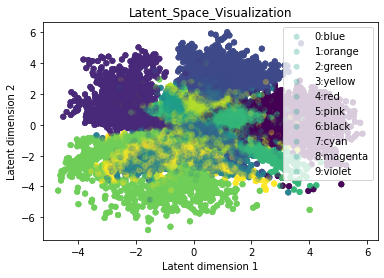

<ipython-input-81-b09d6b221591>:216: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "cmap" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig("latent_space.png", cmap = "Greys")


In [ ]:
main()

In [ ]:
args = parse_args()
vae = VAE(args)
vae.train()

Epoch: 0, Iter: 0, ELBO:-549.23974609375
Epoch: 1, Iter: 100, ELBO:-186.56991577148438


In [ ]:
mu = torch.Tensor([0.0,0.0]).reshape(1,2)
sigma_square = torch.Tensor([1.0,1.0]).reshape(1,2)
z = vae.sample_diagonal_gaussian(mu, sigma_square)
output_dec =(vae.decoder(z).view(-1,1,28,28).detach().numpy())
output_dec = np.reshape(output_dec, (28,28))
import cv2
cv2.imwrite("in.png",output_dec*255)


True

In [ ]:
vae.visualize_inter_class_interpolation()

In [ ]:
array

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 0., 0., 0

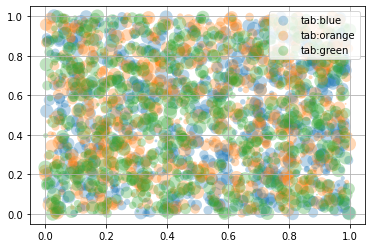

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(19680801)


fig, ax = plt.subplots()
for color in ['tab:blue', 'tab:orange', 'tab:green']:
    n = 750
    x, y = np.random.rand(2, n)
    scale = 200.0 * np.random.rand(n)
    ax.scatter(x, y, c=color, s=scale, label=color,
               alpha=0.3, edgecolors='none')

ax.legend()
ax.grid(True)

plt.show()

In [ ]:
N_data, train_images, train_labels, test_images, test_labels = load_mnist()


In [ ]:
labels = torch.zeros((train_labels.shape[0],1))
for i in range(train_labels.shape[0]):
    labels[i]= torch.Tensor(torch.where(train_labels[i]==1))

In [ ]:
z_mean = torch.zeros((train_images.shape[0],2))
        # TODO: Encode the training data self.train_images
for i in range(train_images.shape[0]):
    z_mean[i] = torch.randn(size = (1,2))

In [ ]:
train_images[0].shape

torch.Size([784])

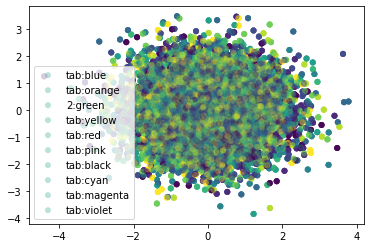

<ipython-input-79-d9d61d53e0ac>:10: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "cmap" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig("image.png", cmap = "Greys")


In [ ]:
fig, ax = plt.subplots()
for color in ['tab:blue', 'tab:orange', '2:green', "tab:yellow", "tab:red","tab:pink","tab:black","tab:cyan","tab:magenta","tab:violet"]:
    
    ax.scatter(z_mean[:,0], z_mean[:,1], c=labels, label=color,
               alpha=0.3, edgecolors='none')

ax.legend()

plt.show()
fig.savefig("image.png", cmap = "Greys")